In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
train = pd.read_csv('~/work/kaggle_kakr_housing/data/train.csv')
test = pd.read_csv('~/work/kaggle_kakr_housing/data/test.csv')

In [3]:
train.shape

(15035, 21)

In [4]:
test.shape

(6468, 20)

In [5]:
train.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [6]:
train.nunique()

id               15035
date               365
price             3263
bedrooms            11
bathrooms           29
sqft_living        863
sqft_lot          7678
floors               6
waterfront           2
view                 5
condition            5
grade               12
sqft_above         789
sqft_basement      271
yr_built           116
yr_renovated        65
zipcode             70
lat               4692
long               716
sqft_living15      682
sqft_lot15        6958
dtype: int64

In [7]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [8]:
train['date'] = train['date'].str[0:8].astype(int)
test['date'] = test['date'].str[0:8].astype(int)

In [9]:
train['price'].describe()

count    1.503500e+04
mean     5.406827e+05
std      3.715247e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

<Axes: xlabel='price', ylabel='Density'>

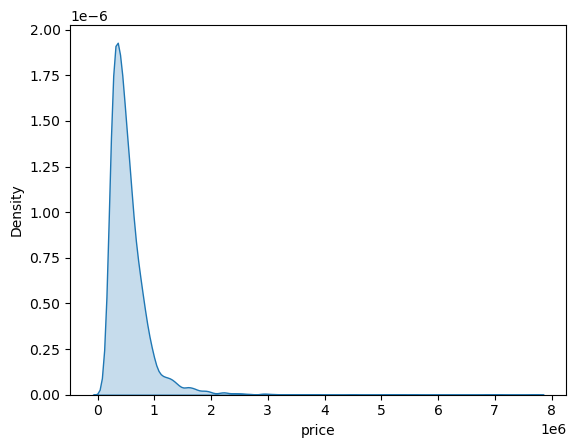

In [10]:
sns.kdeplot(train['price'], fill=True)

<Axes: xlabel='price', ylabel='Density'>

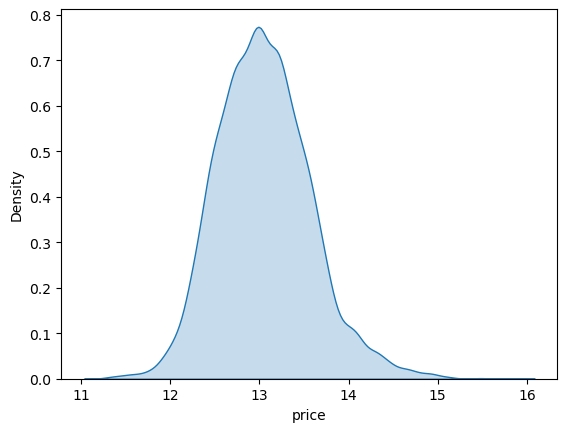

In [11]:
sns.kdeplot(np.log1p(train['price']), fill=True)

In [12]:
train['price'] = np.log1p(train['price'])

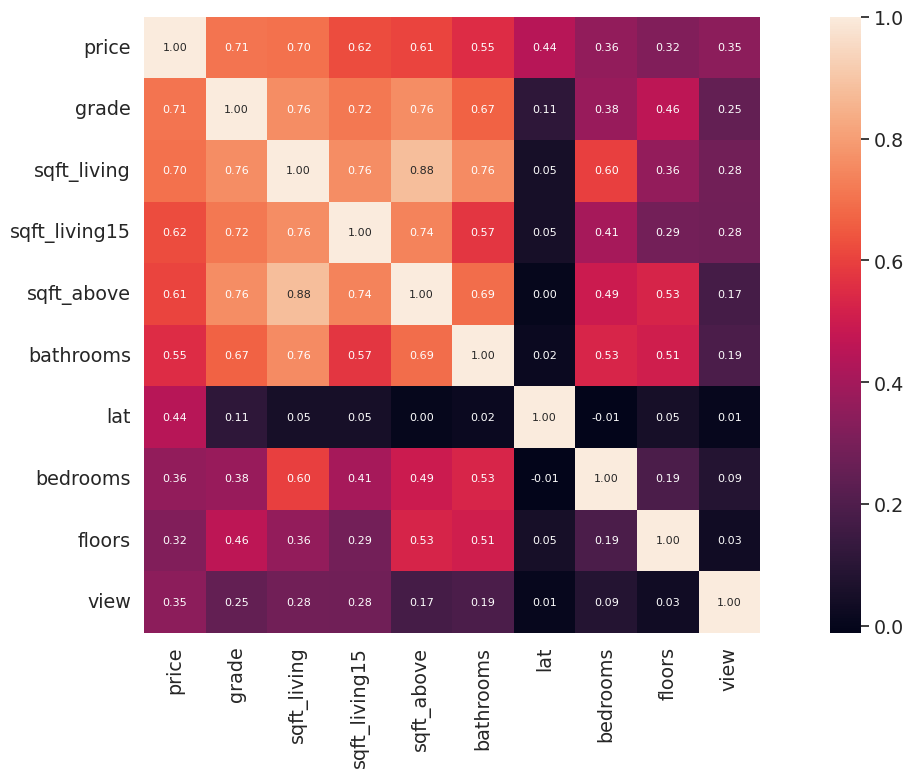

In [13]:
k = 10 
corrmat = abs(train.corr(method='spearman')) 
cols = corrmat.nlargest(k, 'price').index 
cm = np.corrcoef(train[cols].values.T) 
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(18, 8))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 8}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

<Axes: xlabel='grade', ylabel='price'>

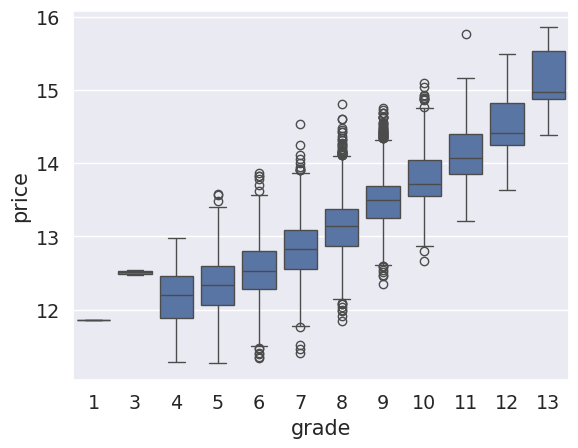

In [14]:
sns.boxplot(x='grade', y='price', data=train)

<Axes: xlabel='grade', ylabel='sqft_living'>

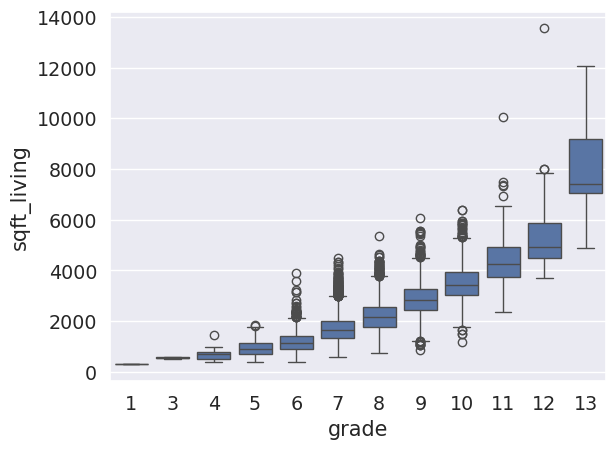

In [15]:
sns.boxplot(x='grade', y='sqft_living', data=train)

<Axes: xlabel='grade', ylabel='bedrooms'>

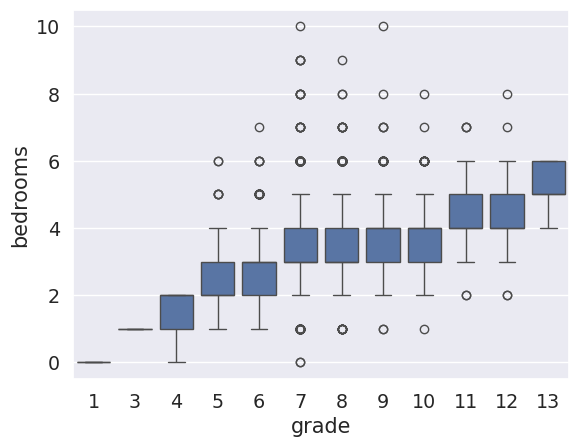

In [16]:
sns.boxplot(x='grade', y='bedrooms', data=train)

In [17]:
train = train[train['sqft_living'] <= 13000]
train = train[~((train['grade'] == 8) & (train['price'] > 14.7))]
train = train[~((train['grade'] > 11) & (train['price'] > 15.5))]
train = train[train['bedrooms'] <= 9]

In [18]:
skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']
for c in skew_columns:
    train[c] = np.log1p(train[c])
    test[c] = np.log1p(test[c])

In [19]:
train['yr_renovated'] = train['yr_renovated'].replace(0, np.nan)
train['yr_renovated'] = train['yr_renovated'].fillna(train['yr_built'])
test['yr_renovated'] = test['yr_renovated'].replace(0, np.nan)
test['yr_renovated'] = test['yr_renovated'].fillna(test['yr_built'])

In [20]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013,12.309987,3,1.00,7.074117,8.639588,1.0,0,0,...,7,7.074117,0.0,1955,1955.0,98178,47.5112,-122.257,1340,5650
1,1,20150225,12.100718,2,1.00,6.647688,9.210440,1.0,0,0,...,6,6.647688,0.0,1933,1933.0,98028,47.7379,-122.233,2720,8062
2,2,20150218,13.142168,3,2.00,7.427144,8.997271,1.0,0,0,...,8,7.427144,0.0,1987,1987.0,98074,47.6168,-122.045,1800,7503
3,3,20140627,12.458779,3,2.25,7.447751,8.827615,2.0,0,0,...,7,7.447751,0.0,1995,1995.0,98003,47.3097,-122.327,2238,6819
4,4,20150115,12.583999,3,1.50,6.966967,9.181118,1.0,0,0,...,7,6.966967,0.0,1963,1963.0,98198,47.4095,-122.315,1650,9711


In [21]:
for df in [train, test]:
    df['total_rooms'] = df['bedrooms'] + df['bathrooms']
    df['grade_condition'] = df['grade'] * df['condition']
    df['sqft_total'] = df['sqft_living'] + df['sqft_lot']
    df['sqft_total_size'] = df['sqft_living'] + df['sqft_lot'] + df['sqft_above'] + df['sqft_basement']
    df['sqft_total15'] = df['sqft_living15'] + df['sqft_lot15'] 
    df['is_renovated'] = df['yr_renovated'] - df['yr_built']
    df['is_renovated'] = df['is_renovated'].apply(lambda x: 0 if x == 0 else 1)

In [22]:
train['per_price'] = train['price']/train['sqft_total_size']
zipcode_price = train.groupby(['zipcode'])['per_price'].agg({'mean','var'}).reset_index()
train = pd.merge(train,zipcode_price,how='left',on='zipcode')
test = pd.merge(test,zipcode_price,how='left',on='zipcode')
del train['per_price']

In [23]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_living15,sqft_lot15,total_rooms,grade_condition,sqft_total,sqft_total_size,sqft_total15,is_renovated,mean,var
0,0,20141013,12.309987,3,1.00,7.074117,8.639588,1.0,0,0,...,1340,5650,4.00,21,15.713705,22.787821,6990,0,0.476389,0.003626
1,1,20150225,12.100718,2,1.00,6.647688,9.210440,1.0,0,0,...,2720,8062,3.00,18,15.858129,22.505817,10782,0,0.489564,0.003682
2,2,20150218,13.142168,3,2.00,7.427144,8.997271,1.0,0,0,...,1800,7503,5.00,24,16.424415,23.851559,9303,0,0.510655,0.002576
3,3,20140627,12.458779,3,2.25,7.447751,8.827615,2.0,0,0,...,2238,6819,5.25,21,16.275366,23.723117,9057,0,0.484890,0.002909
4,4,20150115,12.583999,3,1.50,6.966967,9.181118,1.0,0,0,...,1650,9711,4.50,21,16.148085,23.115052,11361,0,0.489639,0.003175


In [24]:
X = train.drop(columns=['price'])
y = train['price']

In [25]:
X.shape, test.shape

((15028, 28), (6468, 28))

In [26]:
random_state=42

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state, test_size=0.2)

In [28]:
gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)
models = [gboost, xgboost, lightgbm, rdforest]

In [29]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [30]:
df = {}

for model in models:
    model_name = model.__class__.__name__
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    df[model_name] = rmse(y_test, y_pred)
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

df

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003848 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3829
[LightGBM] [Info] Number of data points in the train set: 12022, number of used features: 28
[LightGBM] [Info] Start training from score 13.046489


{'GradientBoostingRegressor': np.float64(127030.37058979119),
 'XGBRegressor': np.float64(115003.27306559232),
 'LGBMRegressor': np.float64(108742.86428755547),
 'RandomForestRegressor': np.float64(132243.22519936162)}

In [31]:
def get_scores(models, train, y):
    df = {}

    for model in models:
        model_name = model.__class__.__name__
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
    return score_df

In [32]:
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [-1, 1, 10],
    'learning_rate': [0.1, 0.05, 0.01]
}

In [33]:
model = LGBMRegressor(random_state=random_state)

In [34]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002371 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3814
[LightGBM] [Info] Number of data points in the train set: 9618, number of used features: 28
[LightGBM] [Info] Start training from score 13.048885
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005980 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3819
[LightGBM] [Info] Number of data points in the train set: 9617, number of used features: 28
[LightGBM] [Info] Start training from score 13.043781
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 

,estimator,LGBMRegressor(random_state=42)
,param_grid,"{'learning_rate': [0.1, 0.05, ...], 'max_depth': [-1, 1, ...], 'n_estimators': [100, 500]}"
,scoring,'neg_mean_squared_error'
,n_jobs,5
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,boosting_type,'gbdt'


In [35]:
grid_model.cv_results_

{'mean_fit_time': array([1.06117225, 3.55731893, 0.41333151, 1.00866032, 0.98486123,
        3.62413745, 1.14515738, 4.03892126, 0.30426116, 1.13740311,
        1.20254431, 3.77488208, 1.20306859, 5.20996957, 0.34958959,
        1.01811428, 1.18931832, 5.33663464]),
 'std_fit_time': array([0.10083319, 0.16925519, 0.0666632 , 0.12017521, 0.04408443,
        0.17637905, 0.11014364, 0.21081676, 0.02456044, 0.06996076,
        0.11396672, 0.12847301, 0.06746478, 0.25276379, 0.03078164,
        0.13959559, 0.03061183, 0.23854885]),
 'mean_score_time': array([0.04987535, 0.3314352 , 0.02853436, 0.09217653, 0.05385904,
        0.29556708, 0.06708775, 0.27142692, 0.01670108, 0.07613015,
        0.05477872, 0.30315604, 0.05253677, 0.30530992, 0.02153258,
        0.09291339, 0.0430428 , 0.25210795]),
 'std_score_time': array([0.00883705, 0.06404205, 0.01084516, 0.02129509, 0.01134221,
        0.01770023, 0.0131574 , 0.01448711, 0.00239641, 0.01299705,
        0.00869676, 0.03458222, 0.01483872, 

In [36]:
params = grid_model.cv_results_['params']
params

[{'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 100},
 {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 500},
 {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 100},
 {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 500},
 {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100},
 {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500},
 {'learning_rate': 0.05, 'max_depth': -1, 'n_estimators': 100},
 {'learning_rate': 0.05, 'max_depth': -1, 'n_estimators': 500},
 {'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 100},
 {'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 500},
 {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 100},
 {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 500},
 {'learning_rate': 0.01, 'max_depth': -1, 'n_estimators': 100},
 {'learning_rate': 0.01, 'max_depth': -1, 'n_estimators': 500},
 {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 100},
 {'learning_rate': 0.01, 'max_depth': 1, 'n_estimat

In [37]:
score = grid_model.cv_results_['mean_test_score']
score

array([-0.02763476, -0.02751105, -0.05271326, -0.03713973, -0.02751747,
       -0.02721743, -0.02903479, -0.02683427, -0.07248004, -0.040863  ,
       -0.02906536, -0.02689601, -0.07994904, -0.02892724, -0.16390382,
       -0.07308444, -0.07994904, -0.02897366])

In [38]:
results = pd.DataFrame(params)
results['score'] = score

results

,learning_rate,max_depth,n_estimators,score
0,0.10,-1,100,-0.027635
1,0.10,-1,500,-0.027511
2,0.10,1,100,-0.052713
3,0.10,1,500,-0.037140
4,0.10,10,100,-0.027517
5,0.10,10,500,-0.027217
6,0.05,-1,100,-0.029035
7,0.05,-1,500,-0.026834
8,0.05,1,100,-0.072480
9,0.05,1,500,-0.040863


In [39]:
results['RMSE'] = np.sqrt(-1 * results['score'])
results

,learning_rate,max_depth,n_estimators,score,RMSE
0,0.10,-1,100,-0.027635,0.166237
1,0.10,-1,500,-0.027511,0.165865
2,0.10,1,100,-0.052713,0.229594
3,0.10,1,500,-0.037140,0.192717
4,0.10,10,100,-0.027517,0.165884
5,0.10,10,500,-0.027217,0.164977
6,0.05,-1,100,-0.029035,0.170396
7,0.05,-1,500,-0.026834,0.163812
8,0.05,1,100,-0.072480,0.269221
9,0.05,1,500,-0.040863,0.202146


In [40]:
results = results.rename(columns={'RMSE': 'RMSLE'})
results

,learning_rate,max_depth,n_estimators,score,RMSLE
0,0.10,-1,100,-0.027635,0.166237
1,0.10,-1,500,-0.027511,0.165865
2,0.10,1,100,-0.052713,0.229594
3,0.10,1,500,-0.037140,0.192717
4,0.10,10,100,-0.027517,0.165884
5,0.10,10,500,-0.027217,0.164977
6,0.05,-1,100,-0.029035,0.170396
7,0.05,-1,500,-0.026834,0.163812
8,0.05,1,100,-0.072480,0.269221
9,0.05,1,500,-0.040863,0.202146


In [41]:
results = results.sort_values('RMSLE')
results

,learning_rate,max_depth,n_estimators,score,RMSLE
7,0.05,-1,500,-0.026834,0.163812
11,0.05,10,500,-0.026896,0.164000
5,0.10,10,500,-0.027217,0.164977
1,0.10,-1,500,-0.027511,0.165865
4,0.10,10,100,-0.027517,0.165884
0,0.10,-1,100,-0.027635,0.166237
13,0.01,-1,500,-0.028927,0.170080
17,0.01,10,500,-0.028974,0.170217
6,0.05,-1,100,-0.029035,0.170396
10,0.05,10,100,-0.029065,0.170486


In [42]:
best_model = LGBMRegressor(max_depth=-1, n_estimators=500, learning_rate=0.05)
best_model.fit(X, y)
prediction = best_model.predict(test)
prediction

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001427 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3862
[LightGBM] [Info] Number of data points in the train set: 15028, number of used features: 28
[LightGBM] [Info] Start training from score 13.047285


array([13.12760102, 13.04266686, 14.13369297, ..., 13.08157041,
       12.67809141, 12.99637501], shape=(6468,))

In [43]:
prediction = np.expm1(prediction)
prediction

array([ 502624.69089095,  461697.27109108, 1374625.98032707, ...,
        480012.93212357,  320644.4931102 ,  440811.54973641],
      shape=(6468,))

In [44]:
submission_path = '~/work/kaggle_kakr_housing/data/sample_submission.csv'
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [45]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.026247e+05
1,15036,4.616973e+05
2,15037,1.374626e+06
3,15038,3.053929e+05
4,15039,3.273030e+05


In [46]:
submission.to_csv('~/work/kaggle_kakr_housing/data/submission8.csv', index=False)

In [47]:
# review
# 피처 엔지니어링 하고 그리드 서치를 했지만 결과가 잘 안나왔다... 원인이 단일모델을 활용해서 그런거 같다.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 